# Derived Measurements
The data used in this tutorial can be downloaded from [Zenodo](https://zenodo.org/records/14259406)

From layer profiles we calculate image derived parameters. We'll start by generating some layers, and applying them to 
quantitative maps.

Taking the average of the outer layers
 is analogous to taking the average of the cortex, similarly taking the average of the inner layer is analogous to taking the average of the medulla. Finally we can calculate the gradient of the central profile which gives information about the cortico-medullary difference. To make things easier, the qlayers package has a helper function to do all this in one go. We're going to use the outer 5 mm of tissue as the outer region and tissue deeper than 15 mm as the inner region. You can set the unit argument to percent to use, for example, the outer 10 % and inner 10 % to define the regions and thus control for kidney size.

Start off with a helper function for plotting slices of images, generating the layers and adding an $R_2^*$ and $T_1$ map to the layers object.

In [76]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns

from qlayers import QLayers, cortical_thickness, slope

sns.set()


def show_slice(img, slice, ax, cmap='gray', clim=None):
    if type(img) is str:
        img = nib.load(img)
    data = img.get_fdata()
    sl = data[:, :, slice]
    if clim is None:
        clim = (sl.min(), sl.max())
    ax.imshow(sl.T, origin='lower', cmap=cmap, clim=clim)
    ax.axis(False)


mask_img = nib.load('data/kidney_mask.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
r2star_map = nib.load('data/r2star.nii.gz')
t1_map = nib.load('data/t1.nii.gz')
qlayers.add_map(r2star_map, 'r2star')
qlayers.add_map(t1_map, 't1')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:11<00:00,  3.93s/it]


The [`slope` function](https://qlayers.readthedocs.io/en/latest/modules.html#qlayers.regression.slope) takes a qlayers object and calculates average properties of the outer, inner and centre region of the kidney with associated uncertainty's. By default, averages are medians, but different aggregation functions can be used. Here the `slope` function is first used to calculate properties based on the number of mm from the surface of the kidney, then the same is done using percent of the maximum depth.

In [77]:
grads = slope(qlayers, outer=5, inner=15, unit='mm')
print(f"Average Outer R2* = {grads.loc['r2star', 'outer']:.2f} +/- {grads.loc['r2star', 'outer_std']:.2f} Hz")
print(f"Average Inner R2* = {grads.loc['r2star', 'inner']:.2f} +/- {grads.loc['r2star', 'inner_std']:.2f} Hz")
print(f"Average R2* Grad  = {grads.loc['r2star', 'grad']:.2f} +/- {grads.loc['r2star', 'grad_se']:.2f} Hz/mm")
grads_percent = slope(qlayers, outer=10, inner=90, unit='percent')
grads

Average Outer R2* = 25.45 +/- 14.79 Hz
Average Inner R2* = 22.72 +/- 7.70 Hz
Average R2* Grad  = 0.15 +/- 0.05 Hz/mm


,inner,outer,grad,inner_std,outer_std,grad_se
r2star,22.717783,25.454324,0.148803,7.699558,14.793482,0.046039
t1,1616.768025,1402.395115,11.842538,311.661846,631.026206,2.380408


## Working with Tissues and Layers
If tissue labels are available, we can use `3DQLayers` to estimate average cortical thickness. In this example, we have a tissue mask where 1 is cortex and 2 is medulla, by using the `add_tissue` method we can add these labels to the layers object. We can only calculate cortical thickness if the tissue labels are explicitly set i.e. `3DQLayers` doesn't just assume that 1 will always be cortex.

In [78]:
tissue_img = nib.load('data/tissue.nii.gz')
qlayers = QLayers(mask_img, thickness=1, pelvis_dist=10, space='layers')
qlayers.add_tissue(tissue_img, tissue_labels=['Cortex', 'Medulla'])
qlayers.add_map(r2star_map, 'r2star')
qlayers.add_map(t1_map, 't1')

Making Mesh
Smoothing Mesh


Pelvis Distance Calculation: 100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


array([0., 1., 2.])

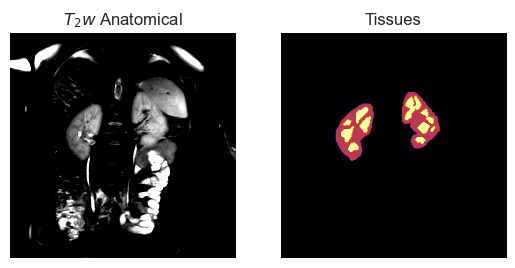

In [79]:
t2w_img = nib.load('data/t2w.nii.gz')
fig, ax = plt.subplots(1, 2)
sl = 6
show_slice(t2w_img, sl, ax[0], clim=(1.5E4, 3.5E4))
ax[0].set_title('$T_2w$ Anatomical')
show_slice(tissue_img, sl, ax[1], cmap='inferno')
ax[1].set_title('Tissues')
tissue = tissue_img.get_fdata()
np.unique(tissue)

The [`cortical_thickness`](https://qlayers.readthedocs.io/en/latest/modules.html#qlayers.thickness.cortical_thickness) function explores the distribution of tissue depths within the kidney. The distribution of cortical tissue with depth can be approximated as a sigmoid/logistic function and the distribution of medullary tissue approximated as a gaussian. The `cortical_thickness` function fits these two equations to the tissue depth distributions and calculates the intercept i.e. the depth at which more voxels are medulla than cortex. This is taken as the average cortical thickness. The function can also estimate the error in the cortical thickness, this is done using a stochastic approach. Lots of samples are drawn from the estimated sigmoid and gaussian parameters and the cortical thickness is calculated for each sample, the mean and standard deviation of the cortical thickness is then returned. Estimating errors is therefore an order of magnitude more computationally expensive and as such, `est_error` is `False` by default.

D:\ppzajd\NextCloud\University\Renal Imaging\Layers\qlayers\qlayers\thickness.py:28: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
D:\ProgramData\Anaconda2\envs\qlayers\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'Cortical Thickness = 8.41 $\\pm$ 2.62 mm')

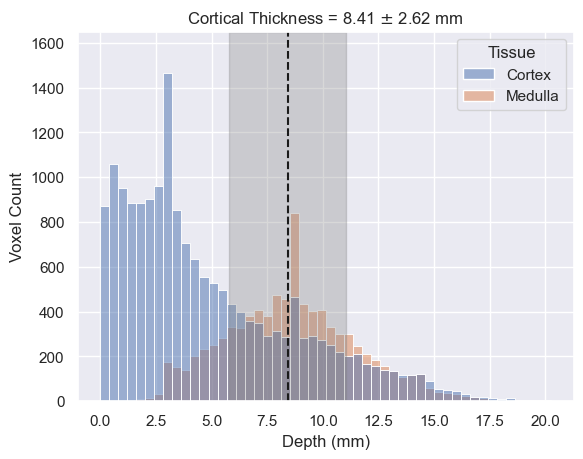

In [80]:
thickness, thickness_err = cortical_thickness(qlayers, est_error=True)
fig, ax = plt.subplots()
g = sns.histplot(qlayers.get_df('wide'), x='depth', hue='tissue', ax=ax)
ax.vlines(thickness, 0, 1650, color='k', linestyle='--')
ax.axvspan(thickness - thickness_err, thickness + thickness_err, color='0.5', alpha=0.3)
ax.set_ylim(0, 1650)
ax.set_xlabel('Depth (mm)')
ax.set_ylabel('Voxel Count')
g.legend_.set_title('Tissue')
ax.set_title(f"Cortical Thickness = {thickness:.2f} $\pm$ {thickness_err:.2f} mm")
